# ***Preprocessing IMDB Dataset for Sentiment Analysis***

# **Importing Libraries**

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Input,SpatialDropout1D, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

# **Loading data and droping Null and Duplicated Values**

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 51% 13.0M/25.7M [00:00<00:00, 43.3MB/s]
100% 25.7M/25.7M [00:00<00:00, 66.7MB/s]


In [3]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [5]:
df=pd.read_csv('/content/IMDB Dataset.csv')
print(df.shape)
df.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [7]:
null_values = df.isnull().sum() #identifying missing values

In [8]:
null_values.index[0]


'review'

In [9]:
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

There are 0 missing values for review and 0 missing values for sentiment.


<ipython-input-9-5d7a3fbb60f7>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))


In [10]:
num_duplicates = df.duplicated().sum() #identify duplicates
print('There are {} duplicate reviews present in the dataset'.format(num_duplicates))

There are 418 duplicate reviews present in the dataset


In [11]:
#view duplicate reviews
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
duplicated_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [12]:
#drop duplicate reviews
df.drop_duplicates(inplace = True)

In [13]:
print('The dataset contains {} rows and {} columns after removing duplicates'.format(df.shape[0],df.shape[1]))

The dataset contains 49582 rows and 2 columns after removing duplicates


# **LowerCasing Text**


In [14]:
# Pick any random Review
df['review'][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

In [15]:
df['review'][4].lower()

'petter mattei\'s "love in the time of money" is a visually stunning film to watch. mr. mattei offers us a vivid portrait about human relations. this is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />this being a variation on the arthur schnitzler\'s play about the same theme, the director transfers the action to the present time new york where all these different characters meet and connect. each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. stylishly, the film has a sophisticated luxurious look. we are taken to see how these people live and the world they live in their own habitat.<br /><br />the only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. a big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

In [16]:
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


# Removing HTML Tags, URLs and Punctuations

In [17]:
# Import Regular Expression
import re

# Function to remove HTML Tags
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'', text)

In [18]:
text = "<html><body><p> Movie 1</p><p> Actor - Aamir Khan</p><p> Click here to <a href='http://google.com'>download</a></p></body></html>"
print(text)
remove_html_tags(text)

<html><body><p> Movie 1</p><p> Actor - Aamir Khan</p><p> Click here to <a href='http://google.com'>download</a></p></body></html>


' Movie 1 Actor - Aamir Khan Click here to download'

In [19]:
# Applying the Function to Remove HTML Tags in our Dataset Colum Review.
df['review'] = df['review'].apply(remove_html_tags)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [20]:
#Regular Expressions to Remove URLs from Text or Whole Corpus.
def remove_url(text):
    pattern = re.compile(r'https?://\S+|www\.\S+')
    return pattern.sub(r'', text)

In [21]:
text1 = 'Check out my notebook https://www.kaggle.com/campusx/notebook8223fc1abb'
print(text1)
remove_url(text1)

Check out my notebook https://www.kaggle.com/campusx/notebook8223fc1abb


'Check out my notebook '

In [22]:
df['review'] = df['review'].apply(remove_url)

In [23]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [24]:
# Storing Punctuation in a Variable
punc = string.punctuation

In [25]:
# The code defines a function, remove_punc1, that takes a text input and removes all punctuation characters from it using
# the translate method with a translation table created by str.maketrans. This function effectively cleanses the text of punctuation symbols.
def remove_punc(text):
    return text.translate(str.maketrans('', '', punc))

In [26]:
# Text With Punctuation.
df['review'][4]

'petter mattei\'s "love in the time of money" is a visually stunning film to watch. mr. mattei offers us a vivid portrait about human relations. this is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. this being a variation on the arthur schnitzler\'s play about the same theme, the director transfers the action to the present time new york where all these different characters meet and connect. each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. stylishly, the film has a sophisticated luxurious look. we are taken to see how these people live and the world they live in their own habitat.the only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. a big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case with most of the people we 

In [27]:
remove_punc(df['review'][4])

'petter matteis love in the time of money is a visually stunning film to watch mr mattei offers us a vivid portrait about human relations this is a movie that seems to be telling us what money power and success do to people in the different situations we encounter this being a variation on the arthur schnitzlers play about the same theme the director transfers the action to the present time new york where all these different characters meet and connect each one is connected in one way or another to the next person but no one seems to know the previous point of contact stylishly the film has a sophisticated luxurious look we are taken to see how these people live and the world they live in their own habitatthe only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits a big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounterthe acting i

In [28]:
df['review'] = df['review'].apply(remove_punc)
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


# **Handling ChatWords**

In [29]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [30]:
# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

In [31]:
# Text
text = 'Omar is AFK'
# Calling function
chat_conversion(text)

'Omar is Away From Keyboard'

In [32]:
df['review'] = df['review'].apply(chat_conversion)

# **StopWords**

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [34]:
from nltk.corpus import stopwords

In [35]:
stopword = stopwords.words('english')

In [36]:
def remove_stopwords(text):
    new_text = []

    for word in text.split():
        if word in stopword:
            new_text.append('')
        else:
            new_text.append(word)
    x = new_text[:]
    new_text.clear()
    return " ".join(x)

In [37]:
print(df['review'][3])

basically theres a family where a little boy jake thinks theres a zombie in his closet his parents are fighting all the timethis movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombieok first of all when youre going to make a film you must decide if its a thriller or a drama as a drama the movie is watchable parents are divorcing arguing like in real life and then we have jake with his closet which totally ruins all the film i expected to see a boogeyman similar movie and instead i watched a drama with some meaningless thriller spots3 out of 10 just for the well playing parents descent dialogs as for the shots with jake just ignore them


In [38]:
remove_stopwords(df['review'][3])

'basically theres  family   little boy jake thinks theres  zombie   closet  parents  fighting   timethis movie  slower   soap opera  suddenly jake decides  become rambo  kill  zombieok first    youre going  make  film  must decide    thriller   drama   drama  movie  watchable parents  divorcing arguing like  real life     jake   closet  totally ruins   film  expected  see  boogeyman similar movie  instead  watched  drama   meaningless thriller spots3   10    well playing parents descent dialogs    shots  jake  ignore '

In [39]:
df['review'] = df['review'].apply(remove_stopwords)
df.head()

,review,sentiment
0,one reviewers mentioned watching 1 oz e...,positive
1,wonderful little production filming techniqu...,positive
2,thought wonderful way spend Tears eyes ...,positive
3,basically theres family little boy jake thi...,negative
4,petter matteis love Tears eyes money vi...,positive


# **Removing Emojies**

In [40]:
# Regular Expressions to Remove the Emojies from Text or Whole Corpus.
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [41]:
# example
text = "The movie was awesome 😘"
print(text)

# Calling Fucntion
remove_emoji(text)

The movie was awesome 😘


'The movie was awesome '

In [42]:
#pip install emoji
# import emoji

In [43]:
# print(text)
# emoji.demojize(text)

In [44]:
df['review'] = df['review'].apply(remove_emoji)

# **Tokenization**

In [ ]:
from nltk.tokenize import word_tokenize,sent_tokenize

In [ ]:
# example
word_tokenize(df['review'][1])

['wonderful',
 'little',
 'production',
 'filming',
 'technique',
 'unassuming',
 'oldtimebbc',
 'fashion',
 'gives',
 'comforting',
 'sometimes',
 'discomforting',
 'sense',
 'realism',
 'entire',
 'piece',
 'actors',
 'extremely',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voices',
 'pat',
 'truly',
 'see',
 'seamless',
 'editing',
 'guided',
 'references',
 'williams',
 'diary',
 'entries',
 'well',
 'worth',
 'watching',
 'terrificly',
 'written',
 'performed',
 'piece',
 'masterful',
 'production',
 'one',
 'great',
 'masters',
 'comedy',
 'life',
 'realism',
 'really',
 'comes',
 'home',
 'little',
 'things',
 'fantasy',
 'guard',
 'rather',
 'use',
 'traditional',
 'dream',
 'techniques',
 'remains',
 'solid',
 'disappears',
 'plays',
 'knowledge',
 'senses',
 'particularly',
 'scenes',
 'concerning',
 'orton',
 'halliwell',
 'sets',
 'particularly',
 'flat',
 'halliwells',
 'murals',
 'decorating',
 'every',
 'surface',
 'terribly',
 'well',
 'done']

In [ ]:
sent_tokenize(df['review'][3])

['basically theres  family   little boy jake thinks theres  zombie   closet  parents  fighting   timethis movie  slower   soap opera  suddenly jake decides  become rambo  kill  zombieok first    youre going  make  film  must decide    thriller   drama   drama  movie  watchable parents  divorcing arguing like  real life     jake   closet  totally ruins   film  expected  see  boogeyman similar movie  instead  watched  drama   meaningless thriller spots3   10    well playing parents descent dialogs    shots  jake  ignore']

# **Stemming**

In [45]:
from nltk.stem.porter import PorterStemmer

In [46]:
# Intilize Stemmer
stemmer = PorterStemmer()

# This Function Will Stem Words
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

In [47]:
stem_words(df['review'][1])

'wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [48]:
df['review'] = df['review'].apply(stem_words)
df.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend tear eye hot summer w...,positive
3,basic there famili littl boy jake think there ...,negative
4,petter mattei love tear eye money visual stun ...,positive


# **data analysis**

In [67]:
#converting target variable to numeric labels
df.sentiment = [ 1 if each == "positive" else 0 for each in df.sentiment]
df.head()

,review,sentiment
0,one review mention watch 1 oz episod youll hoo...,1
1,wonder littl product film techniqu unassum old...,1
2,thought wonder way spend tear eye hot summer w...,1
3,basic there famili littl boy jake think there ...,0
4,petter mattei love tear eye money visual stun ...,1


<ipython-input-134-8c33d211ead4>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(df.sentiment,palette = ['green','red'],order = [1,0])


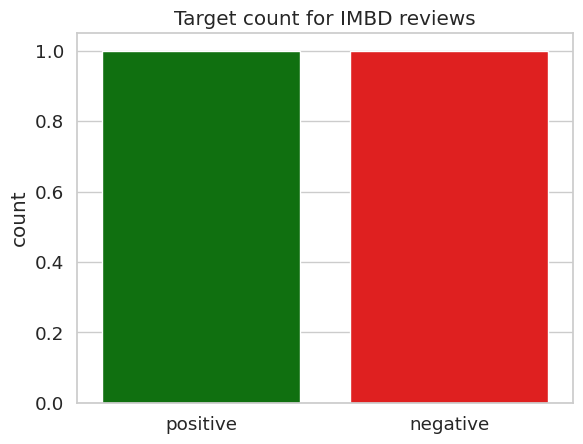

In [ ]:
### Count Plot
sns.set(style = "whitegrid" , font_scale = 1.2)
sns.countplot(df.sentiment,palette = ['green','red'],order = [1,0])
plt.xticks(ticks = np.arange(2),labels = ['positive','negative'])
plt.title('Target count for IMBD reviews')
plt.show()

In [ ]:
print('Positive reviews are', (round(df['sentiment'].value_counts()[0])),'i.e.', round(df['sentiment'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Negative reviews are', (round(df['sentiment'].value_counts()[1])),'i.e.',round(df['sentiment'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Positive reviews are 24695 i.e. 49.81 % of the dataset
Negative reviews are 24882 i.e. 50.19 % of the dataset


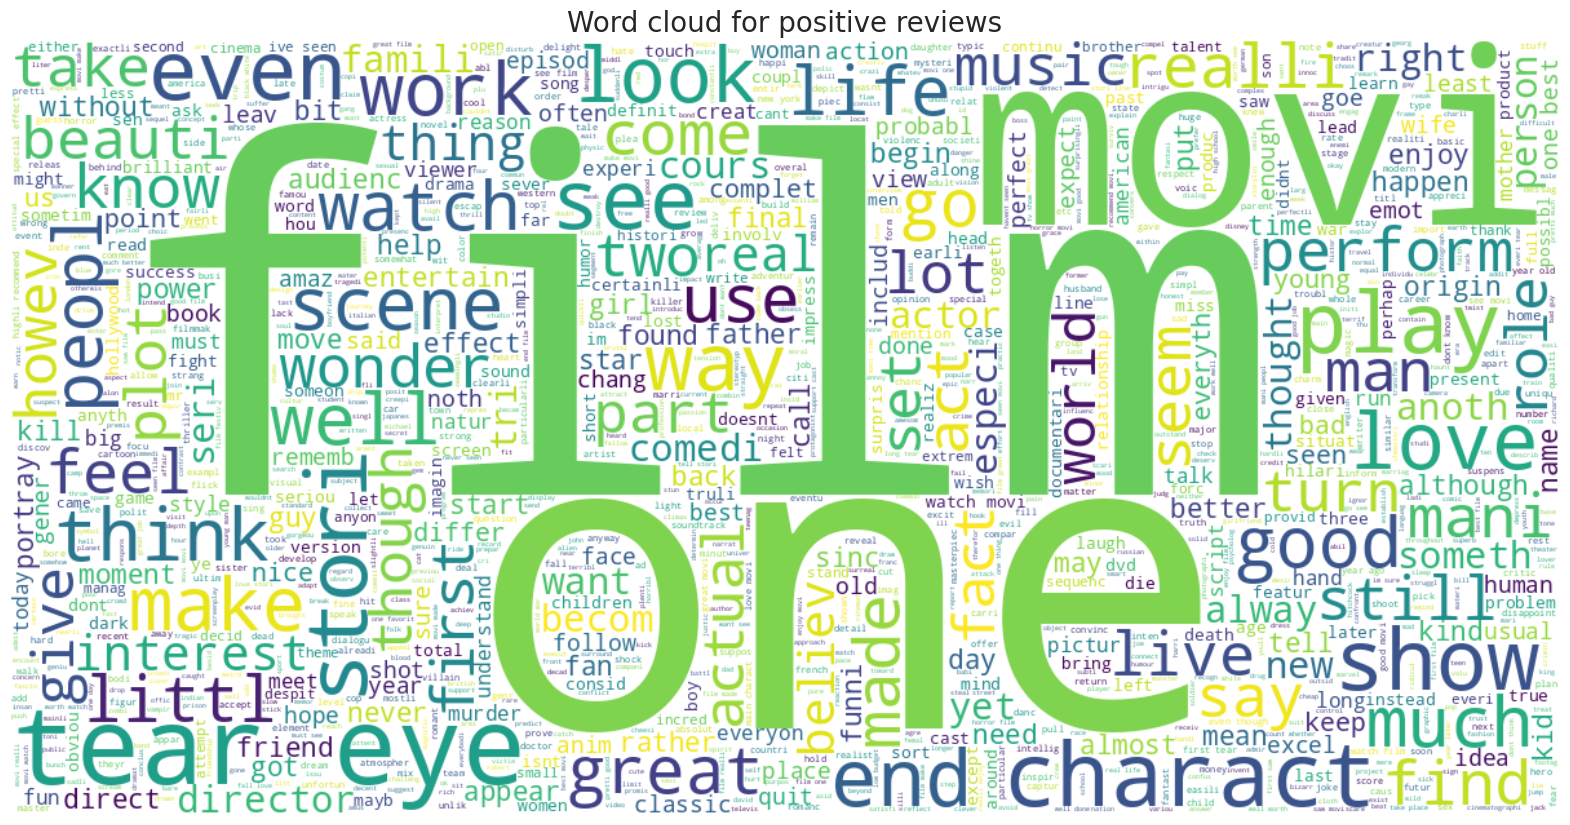

In [ ]:
#word cloud for positive reviews
positive_data = df[df.sentiment == 1]['review']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

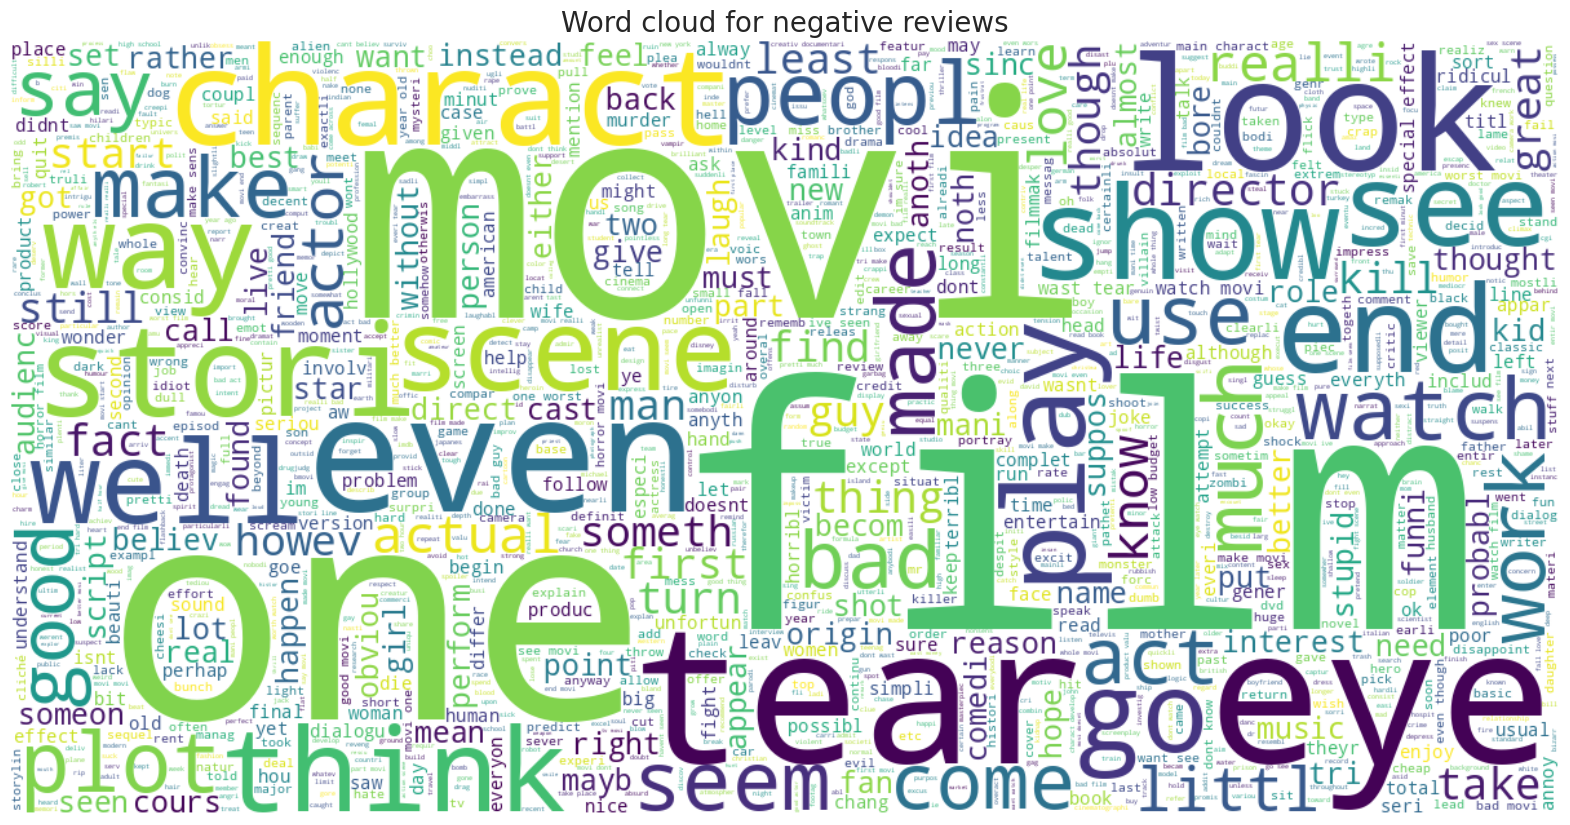

In [ ]:
#word cloud for negative reviews
negative_data = df[df.sentiment == 0]['review']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'review', 'mention', 'watch', '1']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = pd.DataFrame(most_common,columns = ['corpus','countv'])
most_common

,corpus,countv
0,movi,98175
1,film,91423
2,one,52247
3,like,43457
4,good,28699
5,make,28375
6,get,27614
7,see,27347
8,charact,27332
9,watch,26805


In [ ]:
most_common = most_common.sort_values('countv')

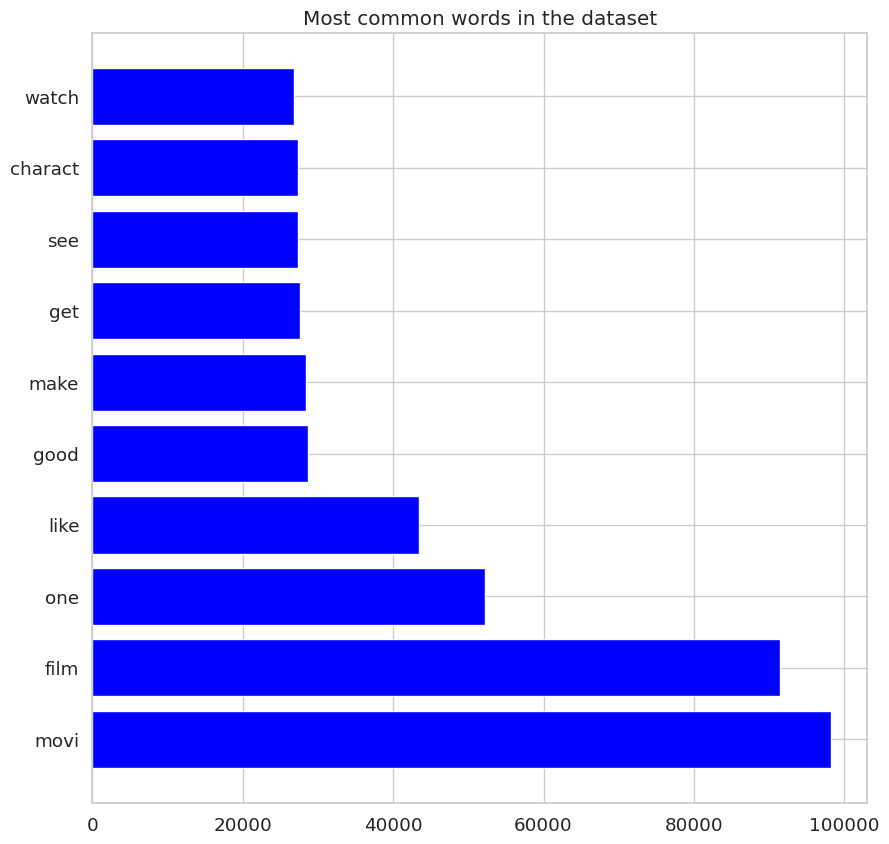

In [ ]:
plt.figure(figsize =(10,10))
plt.yticks(range(len(most_common)), list(most_common.corpus))
plt.barh(range(len(most_common)), list(most_common.countv),align='center',color = 'blue')
plt.title('Most common words in the dataset')
plt.show()

# **Modelling using Deep Learning (LSTM)**

In [71]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))

  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [72]:
# Spliting the dataset 80% - 20%
#train dataset
train, test= train_test_split(df, test_size=0.2, random_state=42)
Xtrain, ytrain = train['review'], train['sentiment']
# test dataset
Xtest, ytest = test['review'], test['sentiment']
print(Xtrain.shape,ytrain.shape)
print(Xtest.shape,ytest.shape)

(39665,) (39665,)
(9917,) (9917,)


In [ ]:
# Split the dataset 80% - 20%
# Train dataset
#train_reviews=df.review[:40000]
#train_sentiments=df.sentiment[:40000]
# Test dataset
#test_reviews=df.review[40000:]
#test_sentiments=df.sentiment[40000:]
#print(train_reviews.shape,train_sentiments.shape)
#print(test_reviews.shape,test_sentiments.shape)

(40000,) (40000,)
(9577,) (9577,)


In [75]:
print(f'Xtrain dtype: {Xtrain.dtype}, shape: {Xtrain.shape}')
print(f'ytrain dtype: {ytrain.dtype}, shape: {ytrain.shape}')

Xtrain dtype: object, shape: (39665,)
ytrain dtype: int64, shape: (39665,)


In [76]:
# LSTM
# Set Up the Tokenizer
MAX_VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
# print(word_index)
V = len(word_index)
print("Vocabulary of the dataset is : ",V)

Vocabulary of the dataset is :  156578


In [77]:
# Create Sequences of Reviews
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)

In [78]:
# Choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

# If we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

Maximum length of sequence in the list: 1433


In [79]:
# When setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of the sequence when considering data only two standard deviations from average: 301


In [80]:
perc_covered = np.sum(np.array(seq_len_list) < max_seq_len) / len(seq_len_list)*100
print('The above calculated number coveres approximately {} % of data'.format(np.round(perc_covered,2)))

The above calculated number coveres approximately 94.5 % of data


In [81]:
# Create padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

In [82]:
# Splitting training set for validation purposes
Xtrain,Xval,ytrain,yval=train_test_split(pad_train,ytrain,
                                             test_size=0.2,random_state=10)

In [64]:
#model = Sequential()
#model.add(Input(shape=(max_seq_len,)))
#model.add(Embedding(input_dim=V + 1,output_dim=100,input_length=max_seq_len))

#model.add(SpatialDropout1D(0.2))
#model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
#model.add(Dense(1, activation='sigmoid'))

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.summary()

In [ ]:
#history = model.fit(Xtrain, ytrain,
#                    epochs=5,
#                   batch_size=32,
#                    validation_data=(Xval, yval),
#                    verbose=2)

In [83]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

#     #early_stop = EarlyStopping(monitor='val_accuracy',
#                                mode='min',
#                                patience = 2 )
#     #checkpoints= ModelCheckpoint(filepath='./',
#                             monitor="val_accuracy",
#                             verbose=0,
#                             save_best_only=True
#                            )
  #  callbacks = [checkpoints,early_stop]


    r = model.fit(Xtrain,ytrain,
                  validation_data = (Xval,yval),
                  epochs = epochs,
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])

    return r,model,n_epochs

In [84]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xval,ytrain,yval,V,D,max_seq_len,epochs)

----Building the model----


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 301)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 301, 64)             │      10,021,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 301, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 301, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 297, 32)             │          10,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 297, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 148, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 148, 256)            │         164,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,278,689 (39.21 MB)

 Trainable params: 10,278,561 (39.21 MB)

 Non-trainable params: 128 (512.00 B)

----Training the network----
Epoch 1/5
992/992 - 39s - 39ms/step - accuracy: 0.7491 - loss: 0.4838 - val_accuracy: 0.8347 - val_loss: 0.3732
Epoch 2/5
992/992 - 35s - 35ms/step - accuracy: 0.8826 - loss: 0.2934 - val_accuracy: 0.8893 - val_loss: 0.2700
Epoch 3/5
992/992 - 42s - 43ms/step - accuracy: 0.9153 - loss: 0.2244 - val_accuracy: 0.8902 - val_loss: 0.2766
Epoch 4/5
992/992 - 42s - 42ms/step - accuracy: 0.9363 - loss: 0.1764 - val_accuracy: 0.8847 - val_loss: 0.2812
Epoch 5/5
992/992 - 38s - 38ms/step - accuracy: 0.9470 - loss: 0.1458 - val_accuracy: 0.8849 - val_loss: 0.3220
992/992 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9803 - loss: 0.0642
Train score: [0.0628398135304451, 0.9807764887809753]
248/248 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8886 - loss: 0.2987
Validation score: [0.32196566462516785, 0.8849111199378967]


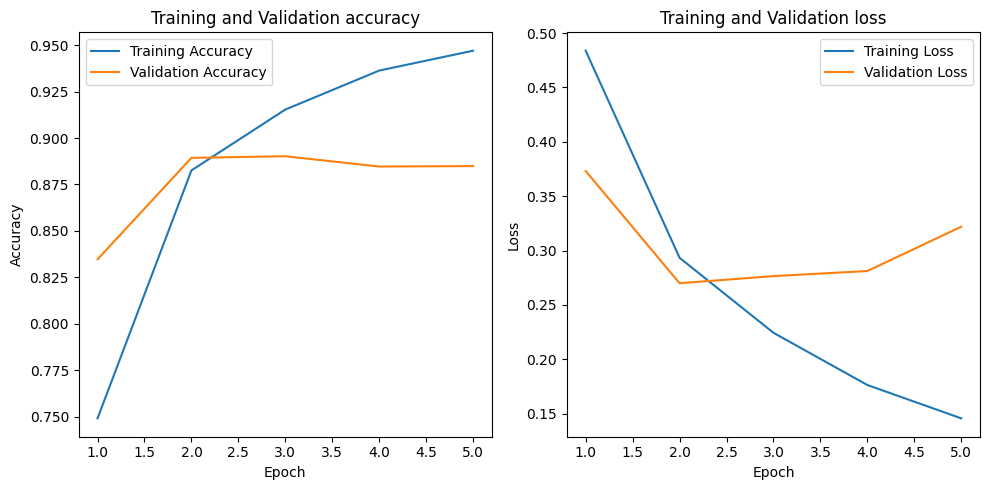

In [85]:
#Plot accuracy and loss
plotLearningCurve(r,n_epochs)

In [86]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
310/310 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8754 - loss: 0.3383
{'loss': 0.3383830785751343, 'compile_metrics': 0.8776847720146179}


310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


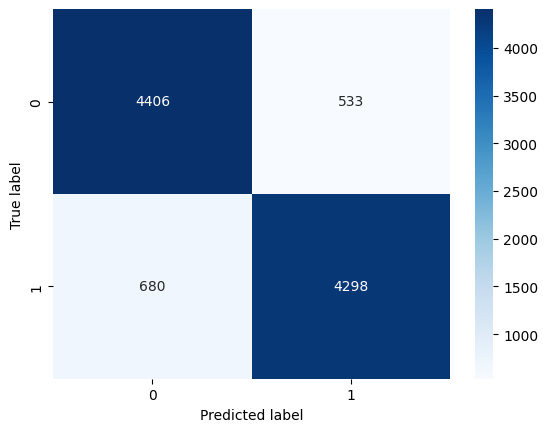

In [89]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [90]:
model.save('my_model.h5')  # Save the model in HDF5 format

In [99]:
# New text input for prediction
new_text = ["I love this movie! It's fantastic!", "This is the worst experience ever.",
            "Started watching this brilliant spin on a superhero show after dinner. Now it's 4 am and I have just watched the whole thing. From the very first episode I was glued to this exciting, interesting and crazy ride",
            "One of those where after watching, you feel like you need to wash the stench off of you."]

# Convert the text to sequences
sequences = tokenizer.texts_to_sequences(new_text)

padded_sequences = pad_sequences(sequences, maxlen=max_seq_len)

In [100]:
# Make predictions
predictions = model.predict(padded_sequences)

# Assuming a binary classification, apply a threshold to get class labels
threshold = 0.5  # Typically, for binary classification
predicted_classes = (predictions > threshold).astype(int)

# Print the predicted classes
for text, pred in zip(new_text, predicted_classes):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f'Text: "{text}" - Sentiment: {sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Text: "I love this movie! It's fantastic!" - Sentiment: Positive
Text: "This is the worst experience ever." - Sentiment: Negative
Text: "Started watching this brilliant spin on a superhero show after dinner. Now it's 4 am and I have just watched the whole thing. From the very first episode I was glued to this exciting, interesting and crazy ride" - Sentiment: Positive
Text: "One of those where after watching, you feel like you need to wash the stench off of you." - Sentiment: Negative
